# Simulations of ideal-observer model

In [49]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import rv_discrete, beta, gamma, norm
from scipy import stats
import scipy
# import scipy.stats

Main documentation for this file is this [Wiki page](https://github.com/aernesto/dots-reversal-ideal-obs/wiki/Python-classes-and-methods)

# Class definition

![Classes diagram](images_Jupyter_1/classdiag.png)

In [50]:
class Experiment(object):
    def __init__(self, setof_stim_noise, exp_dt, setof_trial_dur, setof_h, tot_trial,
                 outputs='perf_acc_last_cp', states=np.array([-1, 1]),
                 exp_prior=np.array([.5,.5])):
        self.states = states
        self.setof_stim_noise = setof_stim_noise
        self.setof_trial_dur = setof_trial_dur  # for now an integer in msec.
        self.tot_trial = tot_trial
        self.outputs = outputs
        self.setof_h = setof_h
        self.results = []
        self.exp_prior = exp_prior  # TODO: check that entries >=0 and sum to 1
        
        # exp_dt = 40 msec corresponds to 25 frames/sec (for stimulus presentation)
        try:
            if (self.setof_trial_dur % exp_dt) == 0:
                self.exp_dt = exp_dt  # in msec
            else:
                raise AttributeError("Error in arguments: the Experiment's time"
                                     "step size "
                                     "'exp_dt' "
                                     "does not divide "
                                     "the trial durations 'setof_trial_dur'")
        except AttributeError as err:
            print(err.args)

    # function that switches the environment state that is given as argument
    def switch(self, H):
        try:
            # might be more elegant to use elseif syntax below
            if H in self.states:
                if H == self.states[0]:
                    return self.states[1]
                else:
                    return self.states[0]
            else:
                raise ValueError("Error in argument H: must be an element of "
                                 "Experiment.states")
        except AttributeError as err:
            print(err.args)

    def launch(self, observer, singleTrialOutputs):
        # boolean variables telling the script what to plot
        printEnvt = singleTrialOutputs[0]
        printStim = singleTrialOutputs[1]
        printLLR = singleTrialOutputs[2]
        
        for trial_idx in range(self.tot_trial):
            h = self.setof_h
            duration = self.setof_trial_dur
            stim_noise = self.setof_stim_noise
            trial_number = trial_idx
            if np.random.uniform() < self.exp_prior[0]:
                init_state = self.states[0]
            else:
                init_state = self.states[1]
            curr_exp_trial = ExpTrial(self, h, duration, stim_noise,
                                      trial_number, init_state)
            curr_stim = Stimulus(curr_exp_trial, printStim)
            curr_obs_trial = ObsTrial(curr_exp_trial, curr_stim, observer.dt, self, 
                                      observer.prior_states, observer.prior_h)
            curr_obs_trial.infer()
        # curr_exp_trial.save()
        #            curr_obs_trial.save()
        self.save()

    def save(self):
        print('Supposed to save here')  # temporary

    def parallel_launch(self):
        return 0  # temporary

In [51]:
class ExpTrial(object):
    def __init__(self, expt, h, duration, stim_noise, trial_number,
                 init_state):
        self.expt = expt
        self.true_h = h
        self.duration = duration  # msec
        self.stim_noise = stim_noise
        self.trial_number = trial_number
        self.init_state = init_state
        self.cp_times = self.gen_cp(self.duration, self.true_h)
        self.end_state = self.compute_endstate(self.cp_times.size)
        self.tot_trial = self.expt.tot_trial

    def compute_endstate(self, ncp):
        # the fact that the last state equals the initial state depends on
        # the evenness of the number of change points.
        if ncp % 2 == 0:
            return self.init_state
        else:
            return self.expt.switch(self.init_state)

    #    def save(self):
    #        print('stimulus is:')
    #        print(self.stim)

    # the following is the likelihood used to generate stimulus values,
    #  given the true state H of the environment
    def randlh(self, H):
        # try clause might be redundant (because switch method does it)
        try:
            if H in self.expt.states:
                return np.random.normal(H, self.stim_noise)
            else:
                raise ValueError("Error in argument H: must be an element of "
                                 "Experiment.states")
        except ValueError as err:
            print(err.args)

    '''
    generates poisson train of duration milliseconds with rate true_h in Hz, 
    using the Gillespie algorithm.
    
    print statements are only there for debugging purposes
    '''
    def gen_cp(self, duration, true_h):
        # TODO: Generate a warning if >1 ch-pt occur in Experiment.exp_dt window
        # print('launching gen_cp')

        # convert duration into seconds.
        secdur = duration / 1000.0
        # print('secdur = '), secdur
        '''
        pre-allocate ten times the mean array size 
        for speed, will be shrinked after computation
        '''
        nEntries = int(np.ceil(10 * true_h * secdur))
        # print('allocated entries = '), nEntries

        t = np.zeros(nEntries)
        if nEntries == 0:
            print('change point times are')
            print(t)
            return t
            
        totalTime = 0
        eventIdx = -1

        while totalTime < secdur:
            sojournTime = np.random.exponential(1. / true_h)
            totalTime += sojournTime
            eventIdx += 1
            t[eventIdx] = totalTime

        # trim unused nodes, and maybe last event if occurred beyond secdur

        # print t[0:10]
        lastEvent, idxLastEvent = t.max(0), t.argmax(0)
        # print 'lastEvent = ', lastEvent, 'idxLastEvent = ', idxLastEvent

        if lastEvent > secdur:
            idxLastEvent -= 1

        if idxLastEvent == -1:
            t = np.zeros((0, 1))
        else:
            t = t[0:int(idxLastEvent) + 1]

#         print('change point times are')
#         print(t)
        return t

In [69]:
class Stimulus(object):
    def __init__(self, exp_trial, printStim):
        self.exp_trial = exp_trial
        self.trial_number = self.exp_trial.trial_number
        
        self.binsize = self.exp_trial.expt.exp_dt  # in msec

        # number of bins, i.e. number of stimulus values to compute
        # the first bin has 0 width and corresponds to the stimulus presentation
        # at the start of the trial, when t = 0.
        # So for a trial of length T = N x exp_dt msecs, there will be an observation
        # at t = 0, t = exp_dt, t = 2 x exp_dt, ... , t = T 
        self.nbins = int(self.exp_trial.duration / self.binsize) + 1  

        self.stim = self.gen_stim(printStim)
        
    def gen_stim(self, printStim):

        # stimulus vector to be filled by upcoming while loop
        stimulus = np.zeros(self.nbins)

        # loop variables
        bin_nb = 0  # we start counting bins from 0
        last_envt = self.exp_trial.init_state
        cp_idx = 0

        while bin_nb < self.nbins:
            stim_idx = bin_nb  # index of array entry to fill in

            # check environment state in current bin
            curr_time = bin_nb * self.binsize  # in msec

            if (self.exp_trial.cp_times.size == 0) or (curr_time < self.exp_trial.cp_times[cp_idx]):
                new_envt = last_envt
            else:
                new_envt = self.exp_trial.expt.switch(last_envt)
                if cp_idx < self.exp_trial.cp_times.size - 1:
                    cp_idx += 1

            # compute likelihood to generate stimulus value
            stimulus[stim_idx] = self.exp_trial.randlh(new_envt)

            # update variables for next iteration
            last_envt = new_envt
            bin_nb += 1
            
        if printStim:
            print('A plot of stimulus should appear here')
            plt.figure()
            plt.plot(np.arange(self.nbins), stimulus)
            plt.title('stimulus / observations')
            plt.show()
                     
#         print('stimulus created')
#         print(stimulus)
        return stimulus

In [53]:
class IdealObs(object):
    def __init__(self, dt, expt, prior_states=np.array([.5, .5]), prior_h=np.array([1, 1])):
        self.expt = expt  # reference to Experiment object
        try:
            if (self.expt.setof_trial_dur % dt) == 0:
                self.dt = dt  # in msec
            else:
                raise AttributeError("Error in arguments: the observer's time"
                                     "step size "
                                     "'dt' "
                                     "does not divide "
                                     "the trial durations 'setof_trial_dur'")
        except AttributeError as err:
            print(err.args)

        self.prior_h = prior_h
        self.prior_states = prior_states  # TODO: check that prior_states is a stochastic vector
        
        self.obs_noise = self.expt.setof_stim_noise
        
    # the following is the likelihood used by the ideal observer
    # H = assumed state of the environment
    # x = point at which to evaluate the pdf
    def lh(self, H, x):
        try:
            if H in self.expt.states:
                return scipy.stats.norm(H, self.obs_noise).pdf(x)
            else:
                raise ValueError("Error in argument H: must be an element of "
                                 "Experiment.states")
        except ValueError as err:
            print(err.args)

In [54]:
class ObsTrial(IdealObs):
    def __init__(self, exp_trial, stimulus, dt, expt, prior_states=np.array([.5, .5]), prior_h=np.array([1, 1])):
        super().__init__(dt, expt, prior_states, prior_h)
        self.exp_trial = exp_trial
        self.stimulus = stimulus
        self.llr = []
        self.decision = 0
        self.obs_noise = self.exp_trial.stim_noise
        self.trial_number = self.exp_trial.trial_number
        # artificial observations for testing purposes
#         self.obs = np.array([0.7, -0.2, -2, 3.6])
        self.obs = self.gen_obs()

    def gen_obs(self):
        return self.stimulus.stim

#     def lh(self, H, x):
#         IdealObs.lh(H.x)
    
    def infer(self):
        #  initialize variables
        Hp = self.expt.states[1]
        Hm = self.expt.states[0]
        joint_plus_new = np.zeros(self.stimulus.nbins)
        joint_plus_current = np.copy(joint_plus_new)
        joint_minus_new = np.copy(joint_plus_new)
        joint_minus_current = np.copy(joint_plus_new)
        alpha = self.prior_h[0]
        priorPrec = self.prior_h.sum()
        Pp = np.zeros([self.stimulus.nbins,self.stimulus.nbins])
        Pm = np.copy(Pp)
        
        # get first observation
        x = self.obs[0]
#         print('first obs = ', x)
#         print('Hp = ', Hp)
        
        # First time step 
        # compute joint posterior after first observation: P_{t=0}(H,a=0) --- recall first obs at t=0
        joint_plus_current[0] = self.lh(Hp, x) * self.prior_states[0]
        joint_minus_current[0] = self.lh(Hm, x) * self.prior_states[1]
#         print(joint_plus_current)
        Fd = joint_plus_current[0] + joint_minus_current[0]
        joint_plus_current[0] = joint_plus_current[0] / Fd
#         print(joint_plus_current[0])
        joint_minus_current[0] = joint_minus_current[0] / Fd

        # compute marginals over state
        lp = joint_plus_current[0]
        lm = joint_minus_current[0]
        Pp[:,0] = joint_plus_current.copy()
        Pm[:,0] = joint_minus_current.copy()
        
        # pursue algorithm if interrogation time is greater than 0
        if self.exp_trial.duration == 0:
            print('trial has duration 0 msec')
            # todo: find a way to exit the function
        
        for j in np.arange(self.stimulus.nbins - 1):
#             print('j',j)
            # make an observation
            x = self.obs[j + 1]
            
            # compute likelihoods
            xp = self.lh(Hp, x)
            xm = self.lh(Hm, x)
            
            # update the boundaries (with 0 and j changepoints)
#             print('alpha, priorPrec=',alpha,priorPrec)
            ea = 1 - alpha / (j + priorPrec)
            eb = (j + alpha) / (j + priorPrec)
#             print('ea,eb', ea, eb)
            joint_plus_new[0] = xp * ea * joint_plus_current[0]
            joint_minus_new[0] = xm * ea * joint_minus_current[0]
            joint_plus_new[j + 1] = xp * eb * joint_minus_current[j]
            joint_minus_new[j + 1] = xm * eb * joint_plus_current[j]
#             if j == 2:
#                 print('Hpn', joint_plus_new)
#                 print('Hmn', joint_minus_new)
            # update the interior values
            if j > 0:
                vk = np.arange(2, j + 2);
#                 print('vk',vk)
                ep = 1 - (vk - 1 + alpha) / (j + priorPrec)   #no change
                em = (vk - 2 + alpha) / (j + priorPrec)       #change
#                 print('ep, em =', ep, em)
#                 if j == 2:
#                     print(xp)
#                     print(xm)
#                     print(joint_plus_current)
#                     print(joint_minus_current)
#                     print(vk)
#                     print(joint_plus_current[vk - 1])
#                     print(joint_minus_current[vk - 2])
                joint_plus_new[vk - 1] = xp * (np.multiply(ep, joint_plus_current[vk - 1]) +
                              np.multiply(em, joint_minus_current[vk - 2]))
                joint_minus_new[vk - 1] = xm * (np.multiply(ep, joint_minus_current[vk - 1]) + 
                                            np.multiply(em,joint_plus_current[vk - 2]))
                
            # sum probabilities in order to normalize
#             if j == 2:
#                 print('Hpn', joint_plus_new)
#                 print('Hmn', joint_minus_new)                
            Hs = joint_plus_new.sum() + joint_minus_new.sum()
#             print('sum Hpn', joint_plus_new.sum())
#             print('sum Hmn', joint_minus_new.sum())
#             if j == 2:
#                 print('Hs = ', Hs)
            joint_plus_current = joint_plus_new / Hs
            joint_minus_current = joint_minus_new / Hs
#             if j == 2:
#                 print(joint_plus_current)
#                 print(joint_minus_current)
            Pp[:, j + 1] = joint_plus_current.copy()
            Pm[:, j + 1] = joint_minus_current.copy()
            #compute marginals over state if last iteration
#             if j >= self.stimulus.nbins - 3:
            lp = joint_plus_current.sum()
            lm = joint_minus_current.sum() 
#             print('j',j)
#             if j>0:
#                 print('vk',vk)
#             print('ea, eb',ea, eb)
#             if j>0:
#                 print('ep, em',ep, em)
#             print('Hpn',joint_plus_new)
#             print('Hmn',joint_minus_new)    
#             print('Hpc',joint_plus_current)
#             print('Hmc',joint_minus_current)
                
                
#         print(lp)
#         print(lm)
#         print(Pp)
#         print(Pm)
#         # compute decision (interrogate the system)
#         if np.sign(np.log(lp / lm)) == -1:
#             self.decision = Hm
#         elif np.sign(np.log(lp / lm)) == 1:
#             self.decision = Hp
#         else:
#             if np.random.uniform() < 0.5:
#                 self.decision = Hm
#             else:
#                 self.decision = Hp

# Interactive code

## Choose the ideal-observer's prior over h

Use the sliders below to set the values of the _mode_ and _variance_ of the gamma prior. No need to execute the cell after moving the sliders.  
By executing the cell appearing right after the sliders, the plot of the pdf will be updated.

In [55]:
def g(mode=1.0, variance=3.0, true_h=1):
    return np.array([mode, variance, true_h])
ww = interactive(g, mode=(.01,10,0.01), variance=(0.01,100), true_h=(0.0,30.0,0.01))
display(ww)

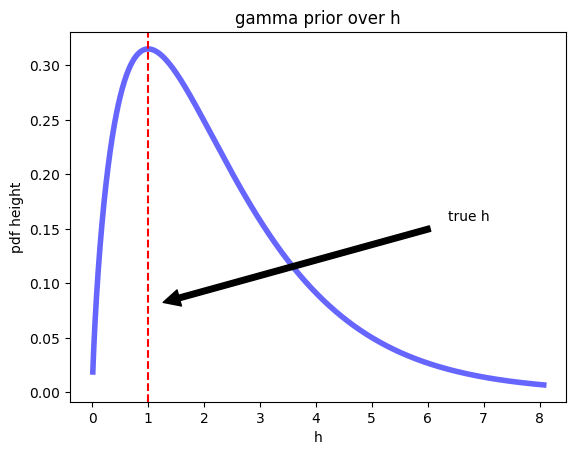

In [56]:
m, v, h = ww.result
#m = 1  # mode of gamma pdf
#v = 2 # var of gamma pdf
beta = m / (2 * v) + np.sqrt(m**2 / (v**2) + 4 / v) / 2  # 1 / scale parameter of gamma pdf
alpha = m * beta + 1   # shape parameter of gamma pdf
x = np.linspace(gamma.ppf(0.0001, alpha, scale = 1 / beta),gamma.ppf(0.99, alpha, scale = 1 / beta), 5000)
fig = plt.figure(1)
ax = fig.add_subplot(111)
y = gamma.pdf(x, alpha, scale = 1 / beta)
plt.plot(x, y,'b-', lw=4, alpha=0.6, label='gamma pdf')
plt.axvline(x=h, color='red', linestyle='--')
xlim = ax.get_xlim()
ax.annotate('true h', xy=(h, .25*y.max()), xytext=(.75*xlim[1], .5*y.max()),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.title('gamma prior over h')
plt.xlabel('h')
plt.ylabel('pdf height')
plt.show()

In [57]:
# This cell is for using the shape and 1/scale parameters of the gamma prior directly
# def g(a=1.0, b=1.0):
#     return np.array([a, b])
# ww = interactive(g, a=(1,40), b=(1,40))
# display(ww)

## Choose ideal-observer's SNR

In [58]:
def f(SNR=1.0):
    return SNR
w = interactive(f, SNR=(0.01,500,0.01))
display(w)

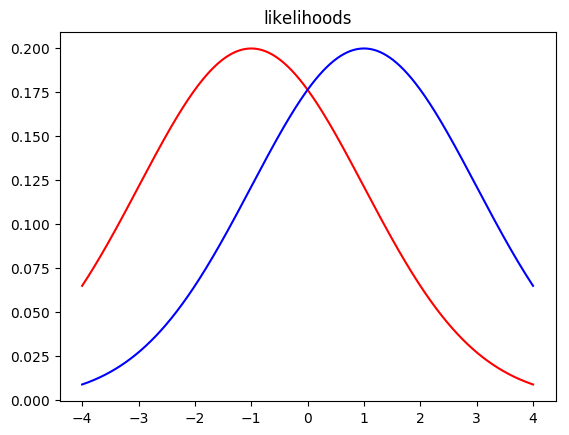

In [59]:
x = np.linspace(-4,4,1000)
SNR = w.result
sigma = 2 / SNR  # distance between means is 2 by default (-1,1)
# print(sigma)
plt.figure(2)
plt.plot(x, norm.pdf(x,-1,sigma),'r-')
plt.plot(x,norm.pdf(x,1,sigma),'b-')
plt.title('likelihoods')
plt.show()

## Choose trial duration (msec)

In [60]:
x_widget = widgets.IntSlider(min=1, max=1000, value=40)
y_widget = widgets.IntSlider(min=0, max=10000, value=1000, step=x_widget.value)

def update_y_step(*args):
    y_widget.step = x_widget.value
x_widget.observe(update_y_step, 'value')

def printer(dt, T):
    print(int(T / dt + 1), ' observations per trial')
interact(printer, dt=x_widget, T=y_widget);

In [61]:
dt = x_widget.value
T = y_widget.value

## Choose number of trials to simulate

In [62]:
def jj(Trials=1):
    return Trials
xx = interactive(jj, Trials=(1,10000))
display(xx)

In [63]:
Trials = xx.result

## Select the outputs you are interested in
### Single trial outputs

If you are planning to only simulate a single trial, choose the type of outputs that you want to display (plots)

In [64]:
def kk(envt=True, obs=True, LLR=True):
    return (envt, obs, LLR)
xxx = interactive(kk, envt=True, obs=True, LLR=True)
display(xxx)

In [65]:
envt, obs, LLR = xxx.result
singleTrialOutputs = np.array([envt, obs, LLR])
print(singleTrialOutputs)

[ True  True  True]


## Run simulations
### Recap of your parameters

In [66]:
print('{}\n\n\
{:24} {:>7}\n\
{:24} {:>7}\n\
{:24} {:>7}\n\
{:24} {:>7}\n\
{:24} {:>7}\n\
{:24} {:>7}\n\
{:24} {:>6}\n\
{:24} {:>7}'.format('To change any of these parameter values, use the sliders above and re-compute each cell',
                    'true h', h,
                    'gamma mode', m, 
                    'gamma variance', v, 
                    'SNR', SNR,
                    'trial duration (msec)', T, 
                    'stimulus timestep (msec)', dt,
                    'nb observations per trial', int(T/dt)+1,
                    'nb of trials to simulate', Trials))

To change any of these parameter values, use the sliders above and re-compute each cell

true h                       1.0
gamma mode                   1.0
gamma variance               3.0
SNR                          1.0
trial duration (msec)       1000
stimulus timestep (msec)      40
nb observations per trial     26
nb of trials to simulate       1


### Launch script

A plot of stimulus should appear here


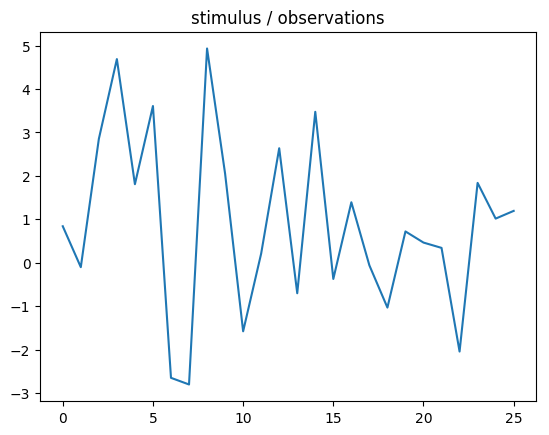

Supposed to save here


In [70]:
Expt = Experiment(setof_stim_noise=sigma, exp_dt=dt, setof_trial_dur=T, setof_h=h,
                  tot_trial=Trials)
Observer = IdealObs(dt=Expt.exp_dt, expt=Expt, prior_h=np.array([alpha, beta]))
Expt.launch(Observer, singleTrialOutputs)